In [2]:
import numpy as np
from numba import njit

In [3]:
@njit
def dejong(state, args):
    # unpack system parameters
    a, b, c, d = args
    
    # unpack the state vector
    x, y = state
    
    # map to the new state
    return np.array([np.sin(a*y) - np.cos(b*x),
                     np.sin(c*x) - np.cos(d*y)])

In [4]:
state = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
dejong(state, args)

array([-1.21475396, -0.56878676])

In [5]:
@njit
def calc_orbit(out, fmap, x0, args):
    ''' Iterate the function fmap through a transient of warmup iterations and return an array of the final orbit.
        Inputs:
            out - output array to store final orbit
            fmap - function of the iterative map
            x0 - initial value
            args - additional arguments taken by fmap
    '''
    # iterate through amp
    out[0,:] = x0
    for i in range(len(out)-1):
        out[i+1,:] = fmap(out[i,:], args)

In [19]:
%%time
N = int(10e6)
x0 = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
out = np.zeros((N, len(x0)))

calc_orbit(out, dejong, x0, args)
print(out[-1,:])

[-0.19607242  1.1624953 ]
CPU times: user 944 ms, sys: 48.1 ms, total: 992 ms
Wall time: 987 ms


In [7]:
@njit
def bin_data(out, z, n):
    ''' Map a continuous coordinate to a discrete point on a grid of length n.
        Inputs:
            out - output array of pixels
            z - array of coordinate values
            n - length of grid
    '''
    out[:] = (z - z.min())/(z.max() - z.min())*(n-1)

In [8]:
nx, ny = 500, 500
bins = np.empty(out.shape, dtype=np.int64)
bin_data(bins[:,0], out[:,0], nx)
bin_data(bins[:,1], out[:,1], ny)
print(bins[-1,:])

[ 17 324]


In [9]:
def get_counts(bins):
    ''' Compute number of occurrences of each binned coordinate value.
        Inputs:
            bins - array of visited pixels
        Outputs:
            counts - logarithm of counts
    '''
    inverse, counts = np.unique(bins[:,0] + bins[:,1]*1j, return_counts=True, return_inverse=True)[1:]
    counts = np.log2(1 + counts[inverse])
    return counts

In [10]:
counts = get_counts(bins)
print(counts)

[3.80735492 1.5849625  1.5849625  ... 6.24792751 6.06608919 6.50779464]


In [11]:
@njit
def make_map(image, bins, counts):
    ''' Populate image pixels with corresponding counts.
        Inputs:
            image - two-dimensional image array
            bins -  array of visited pixels
            counts - array of counts for each pixel
    '''
    for i in range(len(bins)):
        image[bins[i,0], bins[i,1]] = counts[i]

In [12]:
image = np.zeros((nx, ny), dtype=np.int64)
make_map(image, bins, counts)
print('min: ', image.min(), 'max: ', image.max(), 'mean: ', image.mean())

min:  0 max:  11 mean:  1.97116


In [13]:
def make_attractor(image, fmap, s0, args, N):
    ''' Make an image colored by each point's visitation density.
        Inputs:
            image - output image
            fmap - function of the iterative map
            x0 - initial value
            args - additional arguments taken by fmap
            N -  total number of iterations
    '''
    # compute orbit
    out = np.zeros((N, len(s0)))
    calc_orbit(out, fmap, s0, args)

    # format data to grid
    nx, ny = image.shape
    bins = np.zeros(out.shape, dtype=np.int64)
    bin_data(bins[:,0], out[:,0], nx)
    bin_data(bins[:,1], out[:,1], ny)

    # populate image by visitation density
    counts = get_counts(bins)
    make_map(image, bins, counts)

In [17]:
%%time
nx, ny = 500, 500
image = np.zeros((nx, ny), dtype=np.int64)

N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
make_attractor(image, dejong, s0, args, N)

CPU times: user 1.83 s, sys: 232 ms, total: 2.06 s
Wall time: 2.06 s


In [15]:
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'

def plot_attractor(image, palette='inferno'):
    ''' Plot the attractor image.
        Inputs:
          image - two-dimensional image array
          palette - colormap name
        Outputs:
          f, ax - figure and axis objects of resulting plot
    '''
    # set up figure and axes
    f = plt.figure(figsize=(9,9))
    ax = f.add_subplot()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # create a border by padding with some zeros
    npad = int(0.1*image.shape[0])
    image = np.pad(image, ((npad,npad), (npad,npad)), mode='constant')

    # display image
    ax.imshow(np.flipud(image), cmap=palette)
    return f, ax

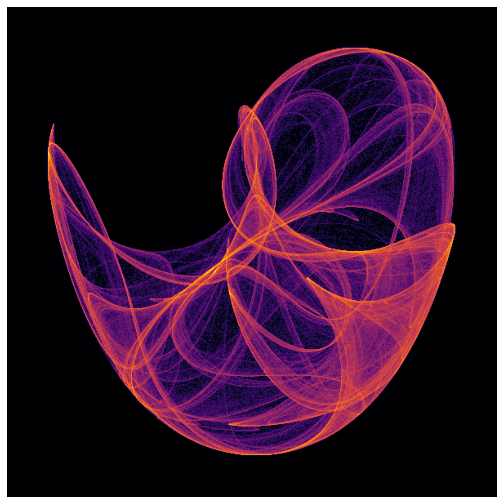

In [16]:
f, ax = plot_attractor(image, palette='inferno');